# The U.S. Senate #

In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
import datetime
import pandas as pd

import sys
sys.path.append('../data')

import congress_db
from setup_db import Candidate, Contribution, Committee
from sqlalchemy import func

session = congress_db.create_session()

df = pd.read_csv('../data/rollCallVotes_cleaned.csv')

/home/isaac/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Party Contributions over an Election Cycle ##

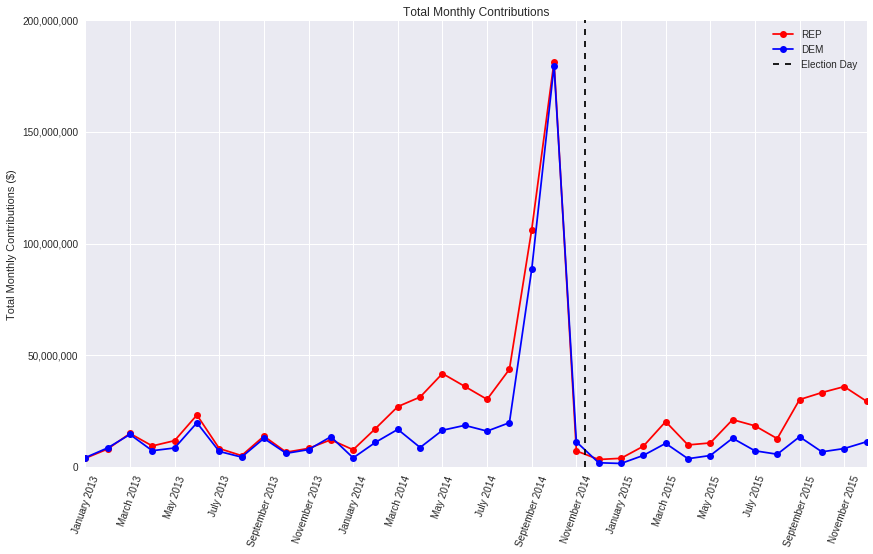

In [2]:
import contributions

plt.figure(figsize=(14, 8))
contributions.plot_monthly_dollars_by_party('REP', color='red')
contributions.plot_monthly_dollars_by_party('DEM', color='blue', election_date=datetime.date(2014, 11, 4))
plt.show()

## Pie chart of party sponsorship breakdown ##


## Party sponsored legislation status (pass/fail) ##

## Top Contributors to Each Party ##

In [3]:
import datetime

def top_contributors_by_party(party):
    return session.query(func.sum(Contribution.tx_amount).label('total_cont'), Committee.name).\
                filter(Contribution.tx_date > datetime.date(2012, 11, 4)).\
                join(Committee).\
                filter(Committee.committee_type.in_('CDEINOPQUVWXYZ')).\
                filter(Committee.designation != 'P').\
                join(Candidate).\
                filter(Candidate.party == party).\
                group_by(Contribution.committee_id).\
                order_by('total_cont desc').\
                all()
                
def plot_top_contributors_by_party(party):
    dollars, committees = zip(*top_contributors_by_party(party))

    plt.figure(figsize=(12, 10))
    sns.barplot(dollars[:20], committees[:20], ci=None)
    
    # format for dollars
    a = plt.gca()
    a.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    plt.xlabel('Total Contributions ($)')
    plt.title('Top Committees contributing to ' + party + ' party')
    plt.show()

/home/isaac/anaconda/lib/python2.7/site-packages/sqlalchemy/sql/compiler.py:575: SAWarning: Can't resolve label reference 'total_cont desc'; converting to text() (this warning may be suppressed after 10 occurrences)
  util.ellipses_string(element.element))
/home/isaac/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


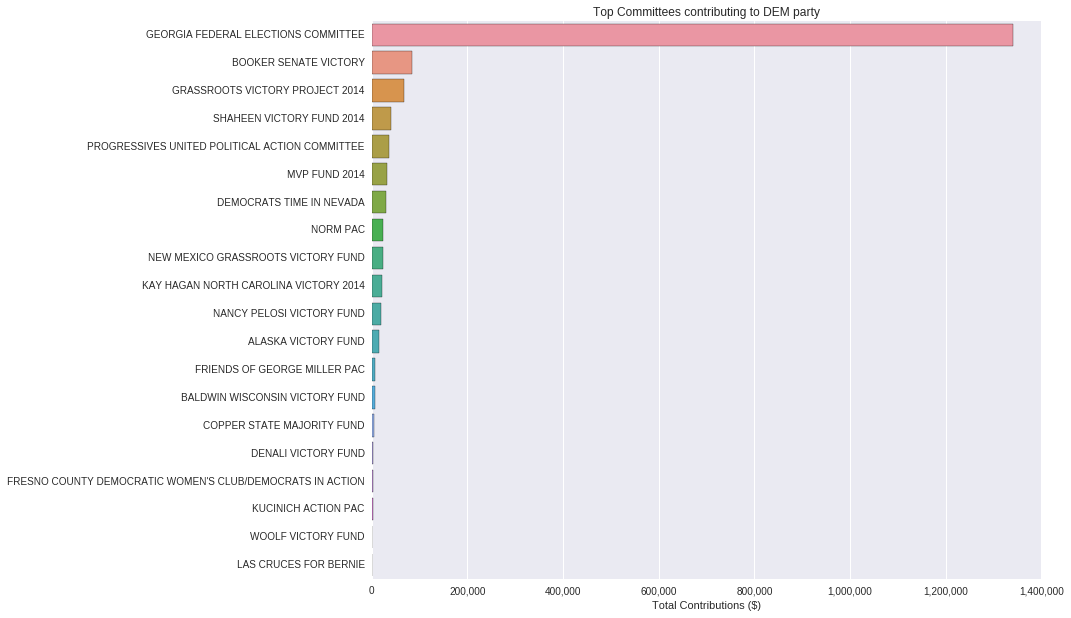

In [4]:
plot_top_contributors_by_party('DEM')

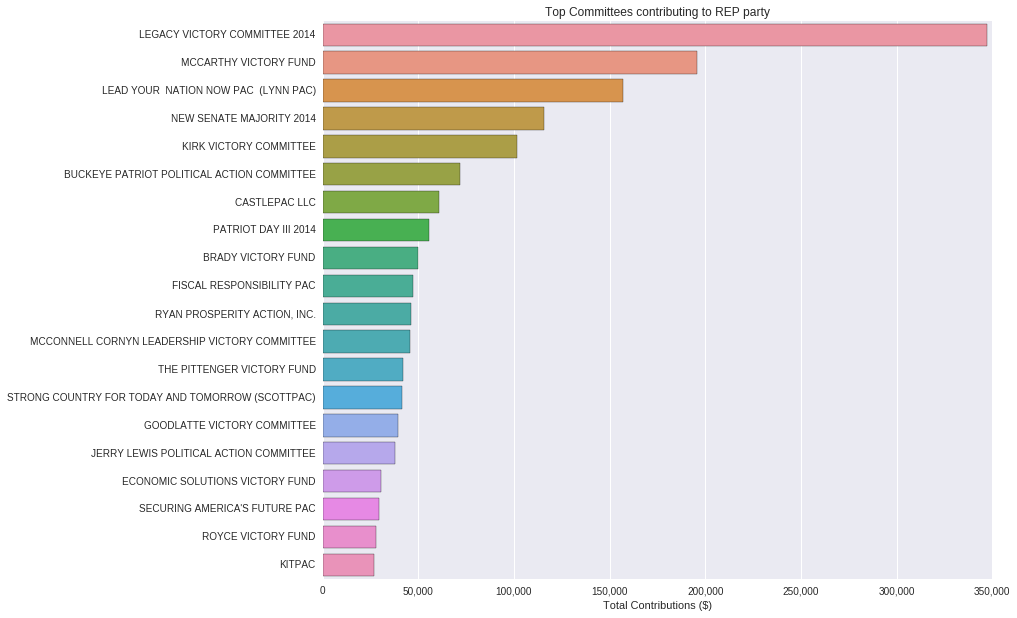

In [5]:
plot_top_contributors_by_party('REP')

## Top senator sponsors ##

# Dynamic Senator Section #

In [29]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from IPython.display import display

senator_names = list(df.columns[:100].values)

senator_widget = widgets.Dropdown(
    options=senator_names,
    description='Senator:',
)
display(senator_widget)

In [51]:
import re
def get_senator_id(Senator):
    parts = re.split('[ ()-]+', Senator)
    last_name = parts[0]
    party_letter = parts[1]
    state = parts[2]
    
    id = session.query(Candidate.id).\
            filter(Candidate.office_st == state).\
            filter(Candidate.name.like('%' + last_name + '%')).\
            filter(Candidate.party.like(party_letter + '%')).\
            first()[0]
    return id

senator_name = senator_widget.value
senator_id = get_senator_id(senator_name)

## Senator profile (name, state, party, picture) ##

In [52]:
senator_info = session.query(Candidate.name, Candidate.office_st, Candidate.party).\
                        filter(Candidate.id == senator_id).\
                        first()
        
full_name, state, party = senator_info

print '%-12s %-20s' % ('Candidate:', full_name)
print '%-12s %-20s' % ('State:', state)
print '%-12s %-20s' % ('Party:', party)

Candidate:   RUBIO, MARCO        
State:       FL                  
Party:       REP                 


## Top Contributors ##

In [53]:
def committee_total_contributions(senator_id):
    return session.query(func.sum(Contribution.tx_amount).label('total_cont'), Committee.name).\
                filter(Contribution.candidate_id == senator_id).\
                join(Committee).\
                group_by(Contribution.committee_id).\
                order_by('total_cont desc').\
                all()
                
def plot_interest_groups(cand_id, name=None):
    contr = committee_total_contributions(cand_id)
    amounts, committees = zip(*contr)
    
    plt.figure(figsize=(10, 7))
    sns.barplot(amounts[:5], committees[:5], ci=None)
    plt.xlabel('Contribution ($)')
    
    # format for dollars
    a = plt.gca()
    a.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    if name:
        plt.title('Top contributors to ' + name)

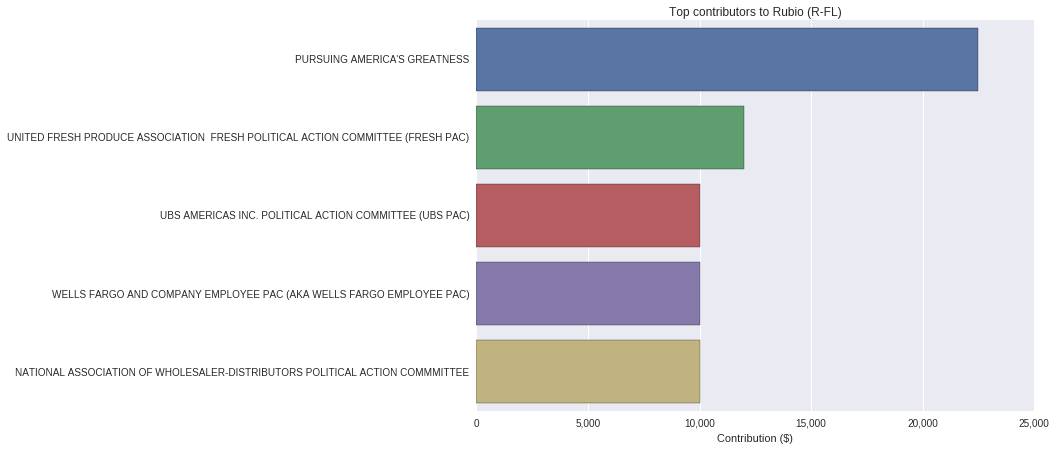

In [54]:
plot_interest_groups(senator_id, senator_name)

## Select a subject for voting record by senator (with sample subject) ##

In [61]:
topics = list(df.columns[105:-2].values)
topics_widget = widgets.Dropdown(
    options=topics,
    description='Topic:',
)
display(topics_widget)

662


In [ ]:
topic = topics_widget.value
print topic

## Sponsorship record (pass/fail) ##

## How inline with the party do they vote ##

In [44]:

senators = df.ix[:,0:100]
dems = [col for col in senators.columns if col.split()[1][1] == 'D']
reps = [col for col in senators.columns if col.split()[1][1] == 'R']
other = [col for col in senators.columns if col.split()[1][1] not in 'DR']

all_senator_votes = senators.apply(lambda vote: vote == 'Yea')

def get_average_vote(senators):
    votes = all_senator_votes[senators]
    num_bill_yeas = votes.sum(axis=1)
    percent_bill_yeas = num_bill_yeas / float(len(senators))
    avg_vote = percent_bill_yeas > 0.5
    return avg_vote

df['DEM'] = get_average_vote(dems)
df['REP'] = get_average_vote(reps)

senator_votes = all_senator_votes[senator_name]
senator_inline_votes = df[party] == senator_votes
print sum(senator_inline_votes / float(len(all_senator_votes)))

0.713864306785
